In [110]:
# # Install scikit-learn for all the core metrics and modeling
# %pip install scikit-learn

# # Install imbalanced-learn for handling imbalanced datasets (SMOTE)
# %pip install imbalanced-learn

# import sys
# !{sys.executable} -m pip install -q scikit-learn imbalanced-learn joblib

# 1: Project Setup and Data Acquisition

In [111]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.neural_network import MLPClassifier # Ensure MLP is imported


# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

try:
    df = pd.read_csv('bank-additional.csv', sep=';')
    print("Data loaded.")
except FileNotFoundError:
    print("Error: bank-additional.csv not found. Please ensure the file is in the correct path and try again.")
    df = pd.DataFrame() 

if not df.empty:

    print("INITIAL DATA OVERVIEW")
    print("\nFirst 5 rows:")
    print(df.head())

    print("\n= BASIC STATISTICS =")
    print(df.describe(include='all'))

    print("\nData Types and Missing Values:")
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("✓ No missing values found")
    else:
        print(missing[missing > 0])

    # Check duplicates
    duplicates = df.duplicated().sum()
    print(f"\n== DUPLICATES ==")
    print(f"Found {duplicates} duplicate rows")
    
    print("\nStatistical Summary:")
    print(df.describe(include='all'))
    
    # Target variable distribution
    print("TARGET VARIABLE DISTRIBUTION")
    print(df['y'].value_counts())
    print(f"\nClass Imbalance Ratio: {df['y'].value_counts()['no']/df['y'].value_counts()['yes']:.2f}:1")


Data loaded.
INITIAL DATA OVERVIEW

First 5 rows:
   age          job  marital          education default  housing     loan  \
0   30  blue-collar  married           basic.9y      no      yes       no   
1   39     services   single        high.school      no       no       no   
2   25     services  married        high.school      no      yes       no   
3   38     services  married           basic.9y      no  unknown  unknown   
4   47       admin.  married  university.degree      no      yes       no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0   cellular   may         fri  ...         2    999         0  nonexistent   
1  telephone   may         fri  ...         4    999         0  nonexistent   
2  telephone   jun         wed  ...         1    999         0  nonexistent   
3  telephone   jun         fri  ...         3    999         0  nonexistent   
4   cellular   nov         mon  ...         1    999         0  nonexistent   

  emp.var.ra

# 2: Data Cleaning and Preparation 

In [112]:

if not df.empty:

    # 1. Data Cleaning: Target Variable Encoding 
    # Convert 'yes'/'no' to 1/0 immediately after loading
    df['y'] = df['y'].map({'yes': 1, 'no': 0})
    print("✓ Target variable 'y' successfully encoded (yes=1, no=0).")
    
    # Check for NaN values in the target *after* encoding
    if df['y'].isnull().any():
        df.dropna(subset=['y'], inplace=True)
        print(f" Removed {df['y'].isnull().sum()} rows with NaN in target.")

    # 2. Check for 'unknown' values and duplicates
    print("\n'Unknown' values in categorical features:")
    for col in df.select_dtypes(include='object').columns:
        unknown_count = (df[col] == 'unknown').sum()
        if unknown_count > 0:
            print(f"  • {col}: {unknown_count} ({unknown_count/len(df)*100:.1f}%)")
    
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        df.drop_duplicates(inplace=True)
        print(f" Removed {duplicates} duplicate rows.")
    else:
        print(" No duplicate rows found.")

    # **Feature 1: Has been contacted before?** (0 if pdays=999, 1 otherwise)
    df['was_previously_contacted'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)
    
    # **Feature 2: Campaign Efficiency Indicator** (1 if less than 5 contacts, 0 otherwise)
    df['campaign_successful'] = df['campaign'].apply(lambda x: 1 if x < 5 else 0)
    
    # **Feature 3: Simplify 'poutcome'** (1 for success, 0 for failure/nonexistent)
    df['poutcome_success'] = df['poutcome'].map({'success': 1, 'failure': 0, 'nonexistent': 0})
    print("\n✓ 3 New features created: 'was_previously_contacted', 'campaign_successful', 'poutcome_success'.")

    # Final check of the target distribution after cleaning/encoding
    print("\nFinal Target Distribution:")
    print(df['y'].value_counts(normalize=True))

✓ Target variable 'y' successfully encoded (yes=1, no=0).

'Unknown' values in categorical features:
  • job: 39 (0.9%)
  • marital: 11 (0.3%)
  • education: 167 (4.1%)
  • default: 803 (19.5%)
  • housing: 105 (2.5%)
  • loan: 105 (2.5%)
 No duplicate rows found.

✓ 3 New features created: 'was_previously_contacted', 'campaign_successful', 'poutcome_success'.

Final Target Distribution:
y
0    0.890507
1    0.109493
Name: proportion, dtype: float64


# 4: Data Preprocessing and Creating Pipeline


In [113]:

if not df.empty:
    # Separate features (X) and target (y)
    X = df.drop('y', axis=1)
    y = df['y']


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Testing set size: {X_test.shape[0]} samples")

    # Define feature types
    numerical_features = ['age', 'campaign', 'previous', 'emp.var.rate', 
                          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
                          'was_previously_contacted', 'campaign_successful', 'poutcome_success']
    
    categorical_features = ['job', 'marital', 'education', 'default', 'housing', 
                           'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    
    # Features to scale (excluding binary engineered features)
    features_to_scale = ['age', 'campaign', 'previous', 'emp.var.rate', 
                         'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
    

    # 2. Engineered/Binary Features (To be passed through without scaling)
    engineered_features = ['was_previously_contacted', 'campaign_successful', 'poutcome_success']
    
     # 'duration' is removed for realistic modeling, 'pdays' is replaced by 'was_previously_contacted'
    # Check for features to remove from the scaling list 
    for col in engineered_features + ['pdays', 'duration']:
        if col in features_to_scale:
             features_to_scale.remove(col)


    # Create a preprocessor using ColumnTransformer
        preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features_to_scale),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
            ('bin', 'passthrough', engineered_features)
        ],
        # CRITICAL FIX: Drop 'pdays' and 'duration'. Only explicitly listed features are kept.
        remainder='drop' 
    )
    print("\nColumnTransformer (Preprocessor) created for scaling and encoding.")

# # # --- SMOTE Application (for reporting, showing the effect of balancing) ---    
# #     # Apply preprocessor fit/transform once
# #     # Apply SMOTE to address class imbalance 
#     X_train_processed = preprocessor.fit_transform(X_train)
#     smote = SMOTE(random_state=42)
#     X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)
 
#     print(f"\nTraining set size after SMOTE: {X_train_smote.shape[0]} samples (Balanced)")
#     print(f"Target distribution after SMOTE: \n{y_train_smote.value_counts()}")

# Class imbalance will be handled using class_weight='balanced' in models
print(f"Original training set size: {X_train.shape[0]} samples")
print(f"Target distribution: \n{y_train.value_counts()}")

Training set size: 3295 samples
Testing set size: 824 samples

ColumnTransformer (Preprocessor) created for scaling and encoding.
Original training set size: 3295 samples
Target distribution: 
y
0    2934
1     361
Name: count, dtype: int64


# 5: Feature Selection and Model Selection

In [114]:

if not df.empty:

    # Re-define fixed preprocessor for robustness within this cell
    features_to_scale = ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
    categorical_features = X_train.select_dtypes(include='object').columns.tolist()
    engineered_passthrough = ['was_previously_contacted', 'campaign_successful', 'poutcome_success']
    
    preprocessor_fixed = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features_to_scale),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
            ('bin', 'passthrough', engineered_passthrough)
        ],
        remainder='drop' 
    )
 
    # --- Define Pipelines for Model Comparison
    
    logreg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'))])

    rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))])

    mlp_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', MLPClassifier(random_state=42, max_iter=300))])

    models = {'Logistic Regression': logreg_pipe, 'Random Forest': rf_pipe, 'MLP Classifier': mlp_pipe}

    results = {}
    print("\nTraining and Evaluating Models (using binary labels and class_weight='balanced')...")
    
    for name, model in models.items():
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_test)
        
        # Metrics now calculated correctly on binary labels
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
        results[name] = {'F1-Score': f1, 'Recall': recall, 'ROC AUC': roc_auc}
        print(f"--- {name} ---")
        print(f"F1-Score: {f1:.4f}, Recall: {recall:.4f}, ROC AUC: {roc_auc:.4f}")

    best_model_name = max(results, key=lambda name: results[name]['F1-Score'])
    best_model_pipe = models[best_model_name]
    print(f"\nSelected Model for Tuning (based on F1-Score): **{best_model_name}**")


Training and Evaluating Models (using binary labels and class_weight='balanced')...
--- Logistic Regression ---
F1-Score: 0.4245, Recall: 0.5778, ROC AUC: 0.7579
--- Random Forest ---
F1-Score: 0.3009, Recall: 0.1889, ROC AUC: 0.7685
--- MLP Classifier ---
F1-Score: 0.3077, Recall: 0.2444, ROC AUC: 0.6478

Selected Model for Tuning (based on F1-Score): **Logistic Regression**


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


# 6: Hyperparameter Tuning and Feature Selection

In [115]:
if not df.empty:
   
    best_model_name = 'Logistic Regression' 
    
    # 1. Define the Feature Selection component 
    # Use SelectKBest with f_classif to select features BEFORE LR training.
    feature_selector = SelectKBest(score_func=f_classif) 

    # 2. Define the FINAL PIPELINE: Preprocessor -> Feature Selector -> Classifier (LR)
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), # preprocessor is defined in cell 86
        ('feature_selection', feature_selector), 
        ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)) 
    ])
    
    # 3. Define the parameter grid for Logistic Regression and Feature Selection
    param_grid = {
        # Tuning parameters for Feature Selection
        'feature_selection__k': [20, 30, 'all'], # Tune the number of features to keep
        
        # Tuning parameters for Logistic Regression
        'classifier__C': [0.1, 1, 10], # Regularization strength
        'classifier__penalty': ['l1', 'l2'],
        'classifier__class_weight': ['balanced', None] 
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        final_pipeline, 
        param_grid, 
        cv=5, 
        scoring='roc_auc', # Optimize for ROC AUC
        n_jobs=-1, 
        verbose=1
    )

    print(f"\nStarting GridSearchCV for {best_model_name} with Feature Selection...")
 
    grid_search.fit(X_train, y_train)

    final_model = grid_search.best_estimator_
    print("\nBest Parameters found by GridSearchCV:")
    print(grid_search.best_params_)


Starting GridSearchCV for Logistic Regression with Feature Selection...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters found by GridSearchCV:
{'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'feature_selection__k': 20}


# 7: Evaluation of the Final Model


*** Final Model Performance on Test Set ***
Accuracy: 0.8422
Recall (Subscription 'yes'): 0.6111
Precision (Subscription 'yes'): 0.3667
F1-Score: 0.4583
ROC AUC: 0.7999

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       734
           1       0.37      0.61      0.46        90

    accuracy                           0.84       824
   macro avg       0.66      0.74      0.68       824
weighted avg       0.88      0.84      0.86       824



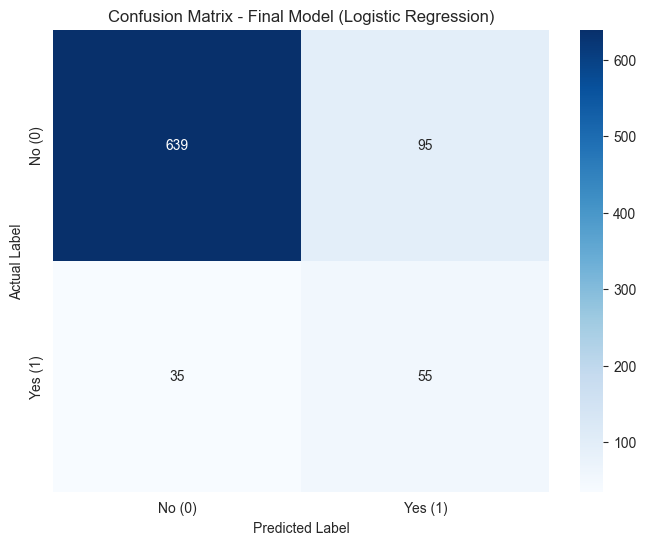


Features Selected by SelectKBest:

Could not display feature selection details. Error: 'SelectKBest' object has no attribute 'k_'

Features Selected by SelectFromModel:


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


In [116]:


if not df.empty:
    y_test_pred = final_model.predict(X_test)
    y_test_proba = final_model.predict_proba(X_test)[:, 1]

    final_accuracy = accuracy_score(y_test, y_test_pred)
    final_recall = recall_score(y_test, y_test_pred)
    final_precision = precision_score(y_test, y_test_pred)
    final_f1 = f1_score(y_test, y_test_pred)
    final_roc_auc = roc_auc_score(y_test, y_test_proba)

    print("\n*** Final Model Performance on Test Set ***")
    print(f"Accuracy: {final_accuracy:.4f}")
    print(f"Recall (Subscription 'yes'): {final_recall:.4f}")
    print(f"Precision (Subscription 'yes'): {final_precision:.4f}")
    print(f"F1-Score: {final_f1:.4f}")
    print(f"ROC AUC: {final_roc_auc:.4f}")


    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))


    # Confusion Matrix Plot 
    cm = confusion_matrix(y_test, y_test_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No (0)', 'Yes (1)'], 
                yticklabels=['No (0)', 'Yes (1)'])
   
    plt.title(f'Confusion Matrix - Final Model ({best_model_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Selection Output 
    try:
        selector = final_model.named_steps['feature_selection']
        print("\nFeatures Selected by SelectKBest:")
        print(f"Number of features kept: {selector.k_}")
        
    except Exception as e:
        print(f"\nCould not display feature selection details. Error: {e}")


    try:
        selector = final_model.named_steps['feature_selection']
        # If the feature names are available, print them
        print("\nFeatures Selected by SelectFromModel:")
    
        print(f"Number of features kept: {selector.transform(X_test).shape[1]}")
    except Exception:
        pass # Ignore if feature selection step is not found in the final model.

In [117]:
# Save the final model
import joblib
joblib.dump(final_model, 'final_bank_marketing_model.joblib')
print("\n✓ Model saved successfully as 'final_bank_marketing_model.joblib'")


✓ Model saved successfully as 'final_bank_marketing_model.joblib'
